# Bayesian Lasso

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

In [7]:
np.random.seed(42)

#### Example 1

We simulated n = 20 data set to fit models and n = 200 data set
to compare prediction errors of proposed models with eight predictors. We let
$β = (3, 1.5, 0, 0, 2, 0, 0, 0)′$ and $σ = 3$. The pairwise correlation between $x_i$ and $x_j$
was set to be $corr(i, j) = 0.5^{|i−j|}$

In [8]:
# Parameters
n_train = 20  # Number of training samples
n_test = 200  # Number of testing samples
p = 8         # Number of predictors
beta1 = np.array([3, 1.5, 0, 0, 2, 0, 0, 0])  # True regression coefficients
sigma = 3     # Standard deviation of noise
corr_decay = 0.5

# Create covariance matrix based on corr(i, j) = 0.5^|i-j|
cov_matrix = np.fromfunction(
    lambda i, j: corr_decay ** np.abs(i - j),
    (p, p),
    dtype=int
)

# Generate training predictors and noise
X_train = np.random.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n_train)
epsilon_train = np.random.normal(loc=0, scale=1, size=n_train)

# Generate training response (y)
y_train = X_train @ beta1 + sigma * epsilon_train

# Generate testing predictors and noise
X_test = np.random.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n_test)
epsilon_test = np.random.normal(loc=0, scale=1, size=n_test)

# Generate testing response (y)
y_test = X_test @ beta1 + sigma * epsilon_test

# Output data
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (20, 8) (20,)
Testing data shape: (200, 8) (200,)


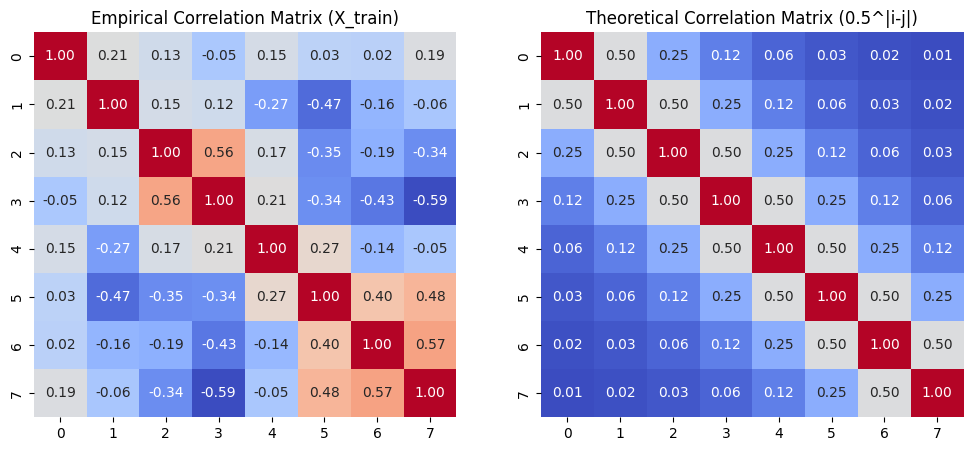

In [9]:
# Calculate empirical correlation matrix
corr_matrix = np.corrcoef(X_train, rowvar=False)

# Calculate theoretical correlation matrix
p = X_train.shape[1]
theoretical_corr_matrix = np.fromfunction(
    lambda i, j: corr_decay ** np.abs(i - j),
    (p, p),
    dtype=int
)

# Plot both side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[0], cbar=False)
axes[0].set_title("Empirical Correlation Matrix (X_train)")
sns.heatmap(theoretical_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[1], cbar=False)
axes[1].set_title("Theoretical Correlation Matrix (0.5^|i-j|)")

# plt.tight_layout()
plt.show()

In [10]:
# Simple linear regression model
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(lr.intercept_)
print(lr.coef_)

0.866193678137718
[ 4.30298364  0.45906469 -0.40606183  0.43799613  2.58414068  0.57767955
 -0.66888869  1.37458676]


##### Frequentist Lasso

In [11]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Define parameter grid for alpha (regularization parameter)
param_grid = {'alpha': [0.01, 0.1, 0.3, 0.5, 0.8, 0.9, 1, 1.1, 2, 5, 10]}

# Perform Grid Search with Cross-Validation
grid = GridSearchCV(Lasso(fit_intercept=True), param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Retrieve the best alpha and corresponding model
best_alpha = grid.best_params_['alpha']
best_model = grid.best_estimator_

# Predictions using the best model
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Evaluation
mse_train_freq = mean_squared_error(y_train, y_pred_train)
mse_test_freq = mean_squared_error(y_test, y_pred_test)

# Print the results
print("Frequentist Lasso Results with Hyperparameter Tuning:")
print(f"Best alpha: {best_alpha}")
print(f"Train MSE: {mse_train_freq:.3f}")
print(f"Test MSE: {mse_test_freq:.3f}")
print("Best Coefficients:", best_model.coef_)

Frequentist Lasso Results with Hyperparameter Tuning:
Best alpha: 0.3
Train MSE: 4.505
Test MSE: 12.689
Best Coefficients: [ 4.07474791  0.         -0.          0.          2.34146127  0.15429963
 -0.          0.81615342]


In [12]:
for i, column in enumerate(range(X_train.shape[1])):
    print(f"Predictor {i+1} correlation with y_train: {np.corrcoef(X_train[:, column], y_train)[0, 1]:.2f}")

Predictor 1 correlation with y_train: 0.81
Predictor 2 correlation with y_train: 0.04
Predictor 3 correlation with y_train: 0.05
Predictor 4 correlation with y_train: -0.03
Predictor 5 correlation with y_train: 0.54
Predictor 6 correlation with y_train: 0.28
Predictor 7 correlation with y_train: 0.00
Predictor 8 correlation with y_train: 0.31


In [13]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=1, l1_ratio=0.7)
elastic_net.fit(X_train, y_train)
print("Elastic Net Coefficients:", elastic_net.coef_)

Elastic Net Coefficients: [ 2.76833273  0.         -0.         -0.          1.47881173  0.07178949
 -0.          0.44299676]


##### Bayesian Lasso
(Using NUTS and not Gibbs sampling)

- With mean estimators :

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda, tau, beta, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1433 seconds.
There were 392 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],4.249,0.634,2.989,5.369,0.032,0.024,384.0,671.0,1.01
beta[1],0.146,0.566,-0.923,1.482,0.015,0.012,1466.0,1469.0,1.00
beta[2],-0.172,0.443,-1.126,0.670,0.012,0.009,1430.0,1767.0,1.01
beta[3],0.079,0.469,-0.961,1.063,0.012,0.010,1623.0,1572.0,1.01
beta[4],2.365,0.696,0.894,3.661,0.033,0.023,615.0,153.0,1.01
beta[5],0.376,0.585,-0.579,1.629,0.024,0.017,650.0,1459.0,1.01
beta[6],-0.172,0.559,-1.491,0.867,0.016,0.012,945.0,1455.0,1.00
beta[7],0.794,0.684,-0.321,2.136,0.025,0.018,691.0,1269.0,1.00
intercept,0.816,0.588,-0.256,1.936,0.030,0.021,384.0,347.0,1.01


Bayesian Lasso Results:
Posterior Means for Coefficients: <xarray.DataArray 'beta' (beta_dim_0: 8)> Size: 64B
array([ 4.24929128,  0.14567708, -0.17215815,  0.07917096,  2.36511296,
        0.37572977, -0.17235063,  0.79368097])
Coordinates:
  * beta_dim_0  (beta_dim_0) int32 32B 0 1 2 3 4 5 6 7
Posterior Mean for Intercept: <xarray.DataArray 'intercept' ()> Size: 8B
array(0.81584377)


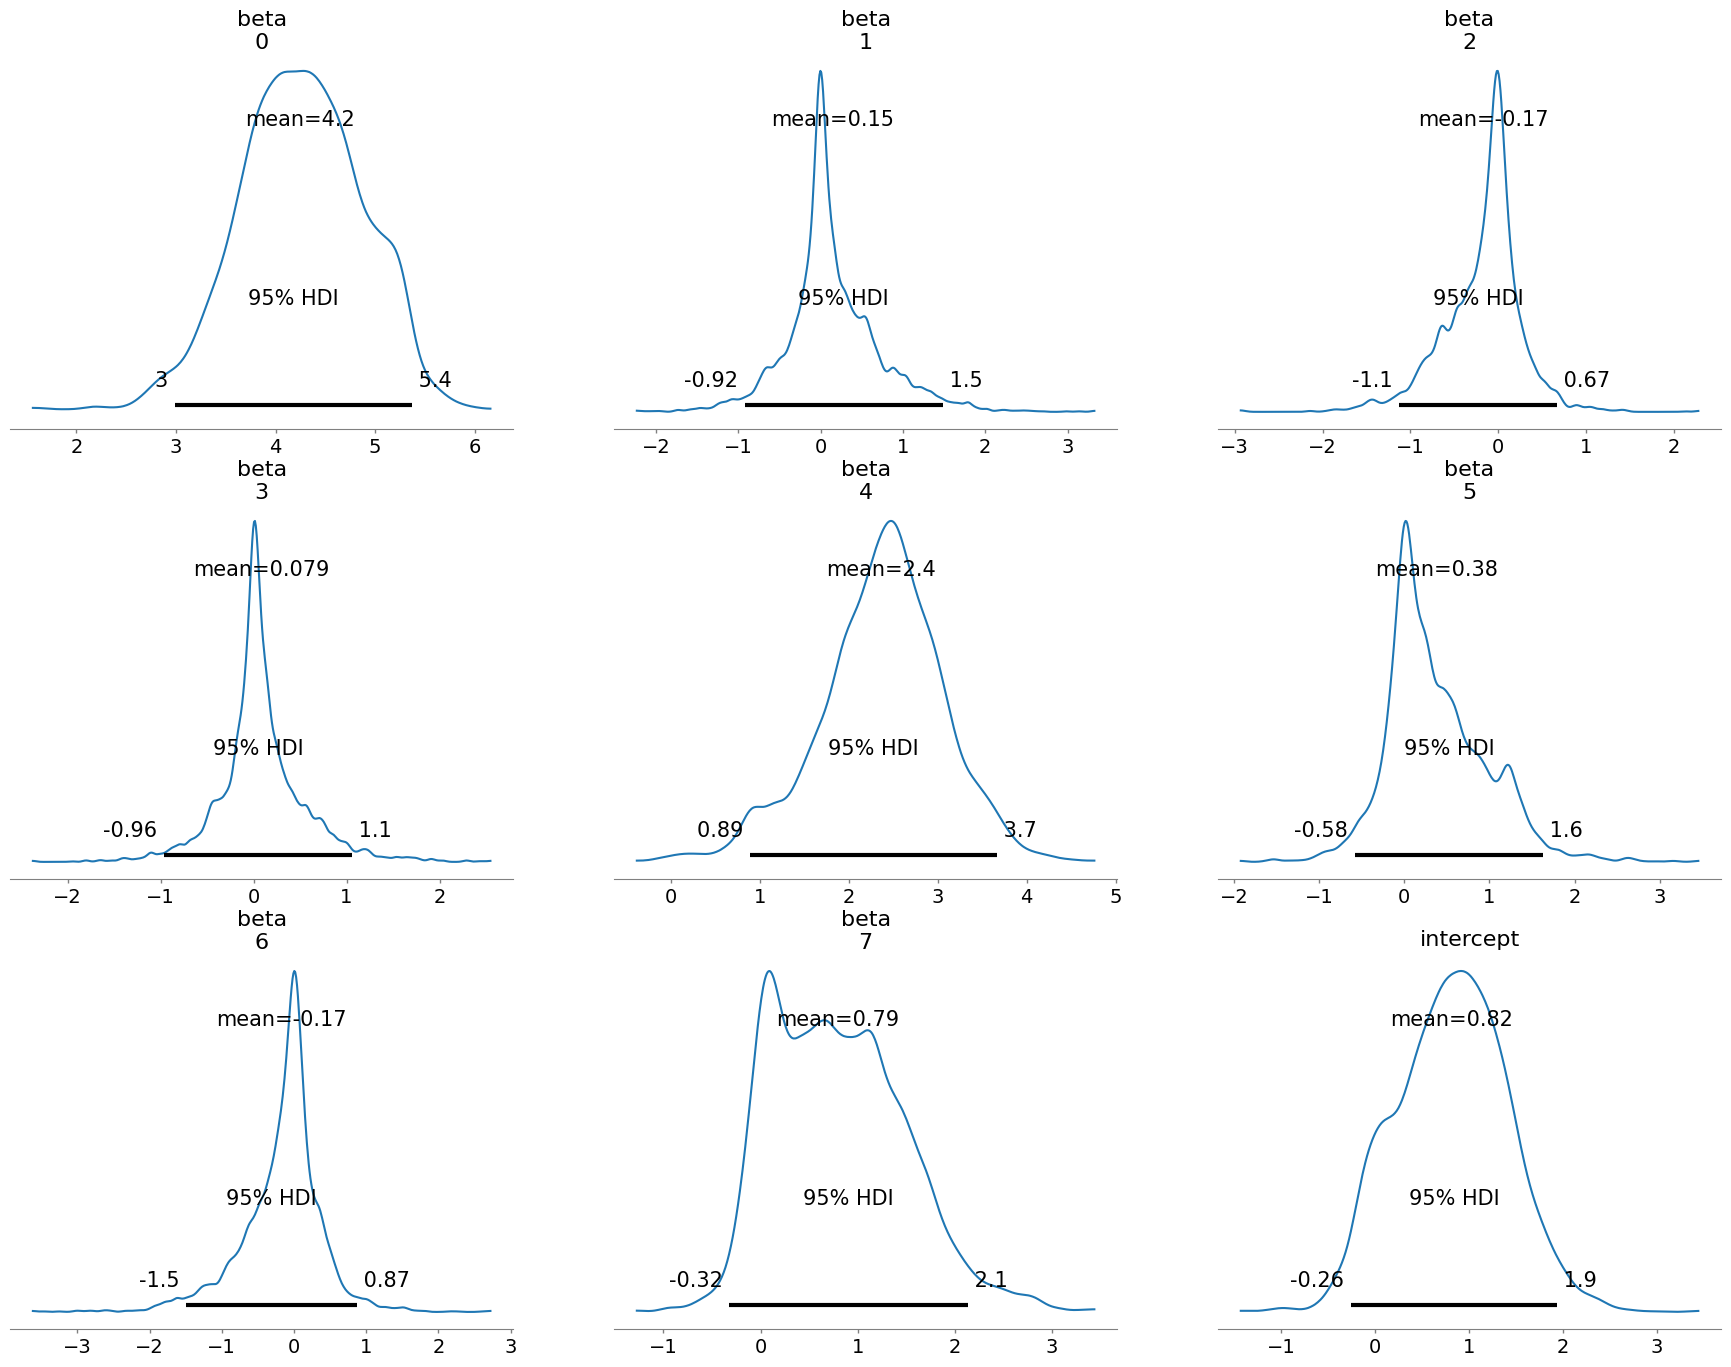

In [14]:
a = 1  # Shape parameter for Gamma prior
b = 0.1  # Scale parameter for Gamma prior

with pm.Model() as bayesian_lasso:
    # Prior for regularization parameter lambda
    lambda_param = pm.Gamma("lambda", alpha=a, beta=b)
    
    # Priors for the regression coefficients
    tau = pm.Exponential("tau", lambda_param, shape=X_train.shape[1])
    beta = pm.Normal("beta", mu=0, sigma=tau, shape=X_train.shape[1])
    
    # Prior for intercept
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Likelihood (data model)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = intercept + pm.math.dot(X_train, beta)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_train)

    # Inference
    trace = pm.sample(1000, tune=1000, target_accept=0.9,  return_inferencedata=True, progressbar=True)

# Posterior summaries
pm.plot_posterior(trace, var_names=["beta", "intercept"], hdi_prob=0.95)

summary = az.summary(trace, var_names=["beta", "intercept"], hdi_prob=0.95)
display(summary)

# Retrieve the posterior means for the coefficients
beta_post_mean = trace.posterior["beta"].mean(axis=(0,1))
intercept_post_mean = trace.posterior["intercept"].mean()
print("Bayesian Lasso Results:")
print("Posterior Means for Coefficients:", beta_post_mean)
print("Posterior Mean for Intercept:", intercept_post_mean)

In [15]:
# Posterior Predictions
with bayesian_lasso:
    posterior_predictive = pm.sample_posterior_predictive(trace)

posterior_predictive_data = posterior_predictive['posterior_predictive']
# print("Available keys inside posterior_predictive:", list(posterior_predictive_data.keys()))

# Extract the predictions
y_pred_samples = posterior_predictive_data['y'].values
# Compute posterior mean of y for each observation (across all chains and draws)
y_pred_mean = y_pred_samples.mean(axis=(0, 1))  # Averaging over chains (axis=0) and draws (axis=1)
# Extract observed y values
y_obs = posterior_predictive['observed_data']['y'].values

# Compute the Mean Squared Error (MSE)
mse = mean_squared_error(y_obs, y_pred_mean)
print(f"MSE: {mse:.3f}")

Sampling: [y]


Output()

MSE: 4.194


In [16]:
# Generate predictions for the test dataset
with bayesian_lasso:
    # Extract posterior samples of beta and intercept
    beta_samples = trace.posterior["beta"].stack(samples=("chain", "draw")).values
    intercept_samples = trace.posterior["intercept"].stack(samples=("chain", "draw")).values

# Compute predicted means for X_test
y_pred_test_samples = np.dot(X_test, beta_samples) + intercept_samples
# Compute posterior predictive mean (average over all samples)
y_pred_test_mean = y_pred_test_samples.mean(axis=1)  # Averaging over all posterior samples

# Compute the Mean Squared Error (MSE) for the test set
mse_test = mean_squared_error(y_test, y_pred_test_mean)
print(f"MSE on Test Set: {mse_test:.3f}")

MSE on Test Set: 12.565


- With mode estimators :

In [17]:
a = 1  # Shape parameter for Gamma prior
b = 0.1  # Scale parameter for Gamma prior

with pm.Model() as bayesian_lasso:
    # Prior for regularization parameter lambda
    lambda_param = pm.Gamma("lambda", alpha=a, beta=b)
    
    # Priors for the regression coefficients
    tau = pm.Exponential("tau", lambda_param, shape=X_train.shape[1])
    beta = pm.Normal("beta", mu=0, sigma=tau, shape=X_train.shape[1])
    
    # Prior for intercept
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Likelihood (data model)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = intercept + pm.math.dot(X_train, beta)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_train)

    # Find the posterior mode
    map_estimate = pm.find_MAP()

# Extract posterior mode for beta and intercept
beta_post_mode = map_estimate["beta"]
intercept_post_mode = map_estimate["intercept"]

# Display results
print("Bayesian Lasso Results:")
print("Posterior Mode for Coefficients:", beta_post_mode)
print("Posterior Mode for Intercept:", intercept_post_mode)

Output()

Bayesian Lasso Results:
Posterior Mode for Coefficients: [ 1.01778867e-13  6.44104898e-14  9.30362303e-14 -2.23324932e-14
  1.02366499e-12 -2.73213109e-14 -1.30183997e-13 -6.80417266e-14]
Posterior Mode for Intercept: 14.351256901403387


Comparisons

In [18]:
# True coefficients
print("True beta: ", beta1)

# Frequentist Lasso Coefficients
print('\n----- FREQUENTIST LASSO -----')
# lasso = LassoCV(cv=5).fit(X_train, y_train)
print("\nFrequentist Lasso Coefficients:", best_model.coef_)
print(f"\nMSE on Train Set: {mse_train_freq:.3f}")
print(f"\nMSE on Test Set: {mse_test_freq:.3f}")

# Bayesian Lasso Posterior Means
print('\n----- BAYESIAN LASSO -----')
# beta_post_mean = trace.posterior["beta"].mean(axis=(0, 1))
print("\nBayesian Lasso Posterior Means:", beta_post_mean)
print(f"\nMSE on Train Set: {mse:.3f}")
print(f"\nMSE on Test Set: {mse_test:.3f}")

True beta:  [3.  1.5 0.  0.  2.  0.  0.  0. ]

----- FREQUENTIST LASSO -----

Frequentist Lasso Coefficients: [ 4.07474791  0.         -0.          0.          2.34146127  0.15429963
 -0.          0.81615342]

MSE on Train Set: 4.505

MSE on Test Set: 12.689

----- BAYESIAN LASSO -----

Bayesian Lasso Posterior Means: <xarray.DataArray 'beta' (beta_dim_0: 8)> Size: 64B
array([ 4.24929128,  0.14567708, -0.17215815,  0.07917096,  2.36511296,
        0.37572977, -0.17235063,  0.79368097])
Coordinates:
  * beta_dim_0  (beta_dim_0) int32 32B 0 1 2 3 4 5 6 7

MSE on Train Set: 4.194

MSE on Test Set: 12.565


#### Example 1 with n= 200 in the training dataset 
We want to assess if for larger samples in the training set, the MSE performance on the test set would the less volatile and lower for the Bayesian Lasso. \
In this case, we simply change $n\_train = 20$ to $n\_train = 200$ in Example 1.

In [19]:
# Parameters
n_train = 200  # Number of training samples
n_test = 200  # Number of testing samples
p = 8         # Number of predictors
beta1 = np.array([3, 1.5, 0, 0, 2, 0, 0, 0])  # True regression coefficients
sigma = 3     # Standard deviation of noise
corr_decay = 0.5

# Create covariance matrix based on corr(i, j) = 0.5^|i-j|
cov_matrix = np.fromfunction(
    lambda i, j: corr_decay ** np.abs(i - j),
    (p, p),
    dtype=int
)

# Generate training predictors and noise
X_train = np.random.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n_train)
epsilon_train = np.random.normal(loc=0, scale=1, size=n_train)

# Generate training response (y)
y_train = X_train @ beta1 + sigma * epsilon_train

# Generate testing predictors and noise
X_test = np.random.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n_test)
epsilon_test = np.random.normal(loc=0, scale=1, size=n_test)

# Generate testing response (y)
y_test = X_test @ beta1 + sigma * epsilon_test

# Output data
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (200, 8) (200,)
Testing data shape: (200, 8) (200,)


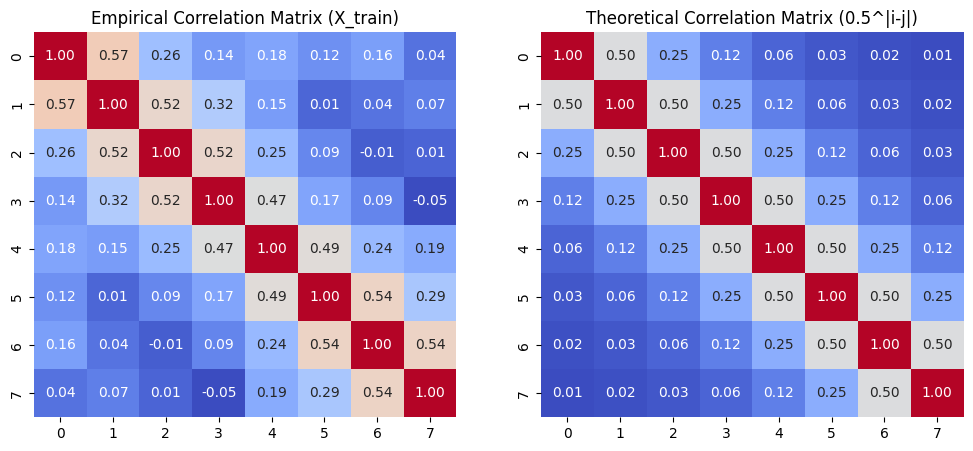

In [20]:
# Calculate empirical correlation matrix
corr_matrix = np.corrcoef(X_train, rowvar=False)

# Calculate theoretical correlation matrix
p = X_train.shape[1]
theoretical_corr_matrix = np.fromfunction(
    lambda i, j: corr_decay ** np.abs(i - j),
    (p, p),
    dtype=int
)

# Plot both side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[0], cbar=False)
axes[0].set_title("Empirical Correlation Matrix (X_train)")
sns.heatmap(theoretical_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[1], cbar=False)
axes[1].set_title("Theoretical Correlation Matrix (0.5^|i-j|)")

# plt.tight_layout()
plt.show()

In [21]:
# Simple linear regression model
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(lr.intercept_)
print(lr.coef_)

-0.09691401651328957
[ 2.95720802  1.43856599  0.0314522   0.01109248  2.25497698 -0.31655006
  0.38403223 -0.27503394]


##### Frequentist Lasso

In [22]:
# Define parameter grid for alpha (regularization parameter)
param_grid = {'alpha': [0.01, 0.1, 0.3, 0.5, 0.8, 0.9, 1, 1.1, 2, 5, 10]}

# Perform Grid Search with Cross-Validation
grid = GridSearchCV(Lasso(fit_intercept=True), param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Retrieve the best alpha and corresponding model
best_alpha = grid.best_params_['alpha']
best_model = grid.best_estimator_

# Predictions using the best model
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Evaluation
mse_train_freq = mean_squared_error(y_train, y_pred_train)
mse_test_freq = mean_squared_error(y_test, y_pred_test)

# Print the results
print("Frequentist Lasso Results with Hyperparameter Tuning:")
print(f"Best alpha: {best_alpha}")
print(f"Train MSE: {mse_train_freq:.3f}")
print(f"Test MSE: {mse_test_freq:.3f}")
print("Best Coefficients:", best_model.coef_)

Frequentist Lasso Results with Hyperparameter Tuning:
Best alpha: 0.01
Train MSE: 8.112
Test MSE: 10.463
Best Coefficients: [ 2.95495819  1.43715661  0.01980978  0.01713793  2.23210049 -0.27967928
  0.34735772 -0.25262413]


##### Bayesian Lasso
(Using NUTS and not Gibbs sampling)

- With mean estimators :

In [23]:
# a = 1  # Shape parameter for Gamma prior
# b = 0.1  # Scale parameter for Gamma prior

# with pm.Model() as bayesian_lasso:
#     # Prior for regularization parameter lambda
#     lambda_param = pm.Gamma("lambda", alpha=a, beta=b)
    
#     # Priors for the regression coefficients
#     tau = pm.Exponential("tau", lambda_param, shape=X_train.shape[1])
#     beta = pm.Normal("beta", mu=0, sigma=tau, shape=X_train.shape[1])
    
#     # Prior for intercept
#     intercept = pm.Normal("intercept", mu=0, sigma=10)
    
#     # Likelihood (data model)
#     sigma = pm.HalfNormal("sigma", sigma=1)
#     mu = intercept + pm.math.dot(X_train, beta)
#     likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_train)

#     # Inference
#     trace = pm.sample(1000, tune=1000, target_accept=0.9,  return_inferencedata=True, progressbar=True)

# # Posterior summaries
# pm.plot_posterior(trace, var_names=["beta", "intercept"], hdi_prob=0.95)

# summary = az.summary(trace, var_names=["beta", "intercept"], hdi_prob=0.95)
# display(summary)

# # Retrieve the posterior means for the coefficients
# beta_post_mean = trace.posterior["beta"].mean(axis=(0,1))
# intercept_post_mean = trace.posterior["intercept"].mean()
# print("Bayesian Lasso Results:")
# print("Posterior Means for Coefficients:", beta_post_mean)
# print("Posterior Mean for Intercept:", intercept_post_mean)

In [24]:
# # Posterior Predictions
# with bayesian_lasso:
#     posterior_predictive = pm.sample_posterior_predictive(trace)

# posterior_predictive_data = posterior_predictive['posterior_predictive']
# # print("Available keys inside posterior_predictive:", list(posterior_predictive_data.keys()))

# # Extract the predictions
# y_pred_samples = posterior_predictive_data['y'].values
# # Compute posterior mean of y for each observation (across all chains and draws)
# y_pred_mean = y_pred_samples.mean(axis=(0, 1))  # Averaging over chains (axis=0) and draws (axis=1)
# # Extract observed y values
# y_obs = posterior_predictive['observed_data']['y'].values

# # Compute the Mean Squared Error (MSE)
# mse = mean_squared_error(y_obs, y_pred_mean)
# print(f"MSE: {mse:.3f}")

In [25]:
# # Generate predictions for the test dataset
# with bayesian_lasso:
#     # Extract posterior samples of beta and intercept
#     beta_samples = trace.posterior["beta"].stack(samples=("chain", "draw")).values
#     intercept_samples = trace.posterior["intercept"].stack(samples=("chain", "draw")).values

# # Compute predicted means for X_test
# y_pred_test_samples = np.dot(X_test, beta_samples) + intercept_samples
# # Compute posterior predictive mean (average over all samples)
# y_pred_test_mean = y_pred_test_samples.mean(axis=1)  # Averaging over all posterior samples

# # Compute the Mean Squared Error (MSE) for the test set
# mse_test = mean_squared_error(y_test, y_pred_test_mean)
# print(f"MSE on Test Set: {mse_test:.3f}")

- With mode estimators :

In [26]:
a = 1  # Shape parameter for Gamma prior
b = 0.1  # Scale parameter for Gamma prior

with pm.Model() as bayesian_lasso:
    # Prior for regularization parameter lambda
    lambda_param = pm.Gamma("lambda", alpha=a, beta=b)
    
    # Priors for the regression coefficients
    tau = pm.Exponential("tau", lambda_param, shape=X_train.shape[1])
    beta = pm.Normal("beta", mu=0, sigma=tau, shape=X_train.shape[1])
    
    # Prior for intercept
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Likelihood (data model)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = intercept + pm.math.dot(X_train, beta)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_train)

    # Find the posterior mode
    map_estimate = pm.find_MAP()

# Extract posterior mode for beta and intercept
beta_post_mode = map_estimate["beta"]
intercept_post_mode = map_estimate["intercept"]

# Display results
print("Bayesian Lasso Results:")
print("Posterior Mode for Coefficients:", beta_post_mode)
print("Posterior Mode for Intercept:", intercept_post_mode)

Output()

Bayesian Lasso Results:
Posterior Mode for Coefficients: [ 3.21842724e+00  9.93137797e-01  2.05519538e-13 -8.32754355e-12
  1.54277603e+00  2.21534671e-13 -5.15351793e-12 -8.21224135e-13]
Posterior Mode for Intercept: -0.4429515807904123


Comparisons

In [27]:
# True coefficients
print("True beta: ", beta1)

# Frequentist Lasso Coefficients
print('\n----- FREQUENTIST LASSO -----')
# lasso = LassoCV(cv=5).fit(X_train, y_train)
print("\nFrequentist Lasso Coefficients:", best_model.coef_)
print(f"\nMSE on Train Set: {mse_train_freq:.3f}")
print(f"\nMSE on Test Set: {mse_test_freq:.3f}")

# Bayesian Lasso Posterior Means
print('\n----- BAYESIAN LASSO -----')
# beta_post_mean = trace.posterior["beta"].mean(axis=(0, 1))
# print("\nBayesian Lasso Posterior Means:", beta_post_mean)
# print(f"\nMSE on Train Set: {mse:.3f}")
# print(f"\nMSE on Test Set: {mse_test:.3f}")

True beta:  [3.  1.5 0.  0.  2.  0.  0.  0. ]

----- FREQUENTIST LASSO -----

Frequentist Lasso Coefficients: [ 2.95495819  1.43715661  0.01980978  0.01713793  2.23210049 -0.27967928
  0.34735772 -0.25262413]

MSE on Train Set: 8.112

MSE on Test Set: 10.463

----- BAYESIAN LASSO -----


#### Example 2 

Example 2 is the same as Example 1, except that $β_j = 0.65$ for all $j$.

In [28]:
np.random.seed(50)

In [29]:
# Parameters
n_train = 20  # Number of training samples
n_test = 200  # Number of testing samples
p = 8         # Number of predictors
beta2 = np.array([0.65]*8)  # True regression coefficients
sigma = 3     # Standard deviation of noise
corr_decay = 0.5

# Create covariance matrix based on corr(i, j) = 0.5^|i-j|
cov_matrix = np.fromfunction(
    lambda i, j: corr_decay ** np.abs(i - j),
    (p, p),
    dtype=int
)

# Generate training predictors and noise
X_train = np.random.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n_train)
epsilon_train = np.random.normal(loc=0, scale=1, size=n_train)

# Generate training response (y)
y_train = X_train @ beta2 + sigma * epsilon_train

# Generate testing predictors and noise
X_test = np.random.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n_test)
epsilon_test = np.random.normal(loc=0, scale=1, size=n_test)

# Generate testing response (y)
y_test = X_test @ beta2 + sigma * epsilon_test

# Output data
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (20, 8) (20,)
Testing data shape: (200, 8) (200,)


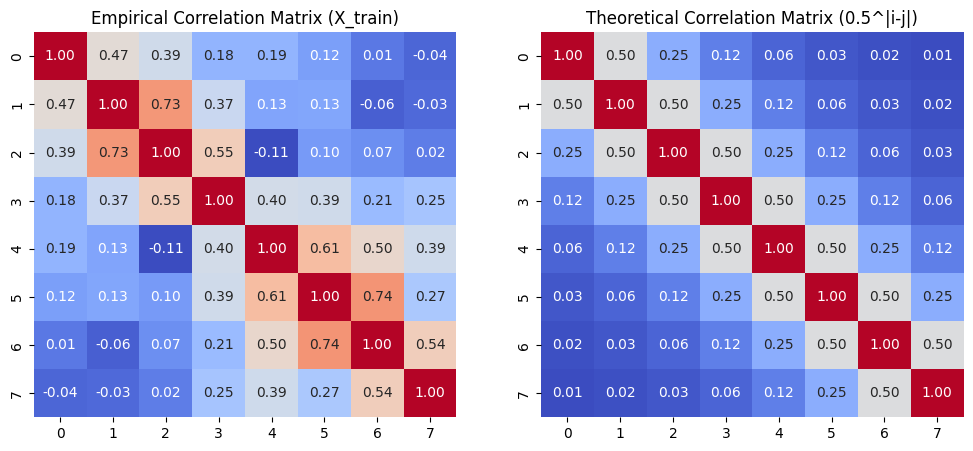

In [30]:
# Calculate empirical correlation matrix
corr_matrix = np.corrcoef(X_train, rowvar=False)

# Calculate theoretical correlation matrix
p = X_train.shape[1]
theoretical_corr_matrix = np.fromfunction(
    lambda i, j: corr_decay ** np.abs(i - j),
    (p, p),
    dtype=int
)

# Plot both side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[0], cbar=False)
axes[0].set_title("Empirical Correlation Matrix (X_train)")
sns.heatmap(theoretical_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[1], cbar=False)
axes[1].set_title("Theoretical Correlation Matrix (0.5^|i-j|)")

plt.show()

In [31]:
# Simple linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(lr.intercept_)
print(lr.coef_)

-1.4857283051301753
[ 0.13759203  1.99025465 -1.46013973  2.35494729  0.36065762  1.23094053
 -0.04254941  0.29337707]


##### Frequentist Lasso

In [32]:
# Define parameter grid for alpha (regularization parameter)
param_grid = {'alpha': [0.01, 0.1, 0.3, 0.5, 0.9, 1, 3, 5, 10]}

# Perform Grid Search with Cross-Validation
grid = GridSearchCV(Lasso(fit_intercept=True), param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Retrieve the best alpha and corresponding model
best_alpha = grid.best_params_['alpha']
best_model = grid.best_estimator_

# Predictions using the best model
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Evaluation
mse_train_freq = mean_squared_error(y_train, y_pred_train)
mse_test_freq = mean_squared_error(y_test, y_pred_test)

# Print the results
print("Frequentist Lasso Results with Hyperparameter Tuning:")
print(f"Best alpha: {best_alpha}")
print(f"Train MSE: {mse_train_freq:.3f}")
print(f"Test MSE: {mse_test_freq:.3f}")
print("Best Coefficients:", best_model.coef_)

Frequentist Lasso Results with Hyperparameter Tuning:
Best alpha: 10
Train MSE: 25.886
Test MSE: 20.020
Best Coefficients: [0. 0. 0. 0. 0. 0. 0. 0.]


In [33]:
#test of an ElasticNet : also bad
elastic_net = ElasticNet(alpha=1, l1_ratio=0.7)
elastic_net.fit(X_train, y_train)
print("Elastic Net Coefficients:", elastic_net.coef_)

Elastic Net Coefficients: [0.         0.63875588 0.         1.42751894 0.70174482 0.84224697
 0.         0.        ]


##### Bayesian Lasso

- With mean estimators :

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda, tau, beta, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1736 seconds.
There were 760 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.121,0.412,-0.679,1.075,0.020,0.014,93.0,581.0,1.04
beta[1],0.777,0.695,-0.275,2.107,0.037,0.026,303.0,1842.0,1.04
beta[2],-0.132,0.537,-1.510,0.857,0.018,0.014,737.0,931.0,1.02
beta[3],1.738,0.707,0.345,3.183,0.067,0.050,113.0,1138.0,1.03
beta[4],0.648,0.745,-0.382,2.310,0.094,0.066,38.0,218.0,1.08
beta[5],0.898,0.677,-0.265,2.183,0.031,0.022,467.0,1788.0,1.07
beta[6],0.033,0.501,-1.092,1.140,0.016,0.014,1063.0,919.0,1.16
beta[7],0.178,0.474,-0.697,1.191,0.041,0.029,83.0,382.0,1.04
intercept,-1.302,0.627,-2.547,0.024,0.019,0.015,973.0,1609.0,1.04


Bayesian Lasso Results:
Posterior Means for Coefficients: <xarray.DataArray 'beta' (beta_dim_0: 8)> Size: 64B
array([ 0.12132149,  0.77716059, -0.13189123,  1.73772888,  0.64826723,
        0.89825987,  0.03287038,  0.17756836])
Coordinates:
  * beta_dim_0  (beta_dim_0) int32 32B 0 1 2 3 4 5 6 7
Posterior Mean for Intercept: <xarray.DataArray 'intercept' ()> Size: 8B
array(-1.30185699)


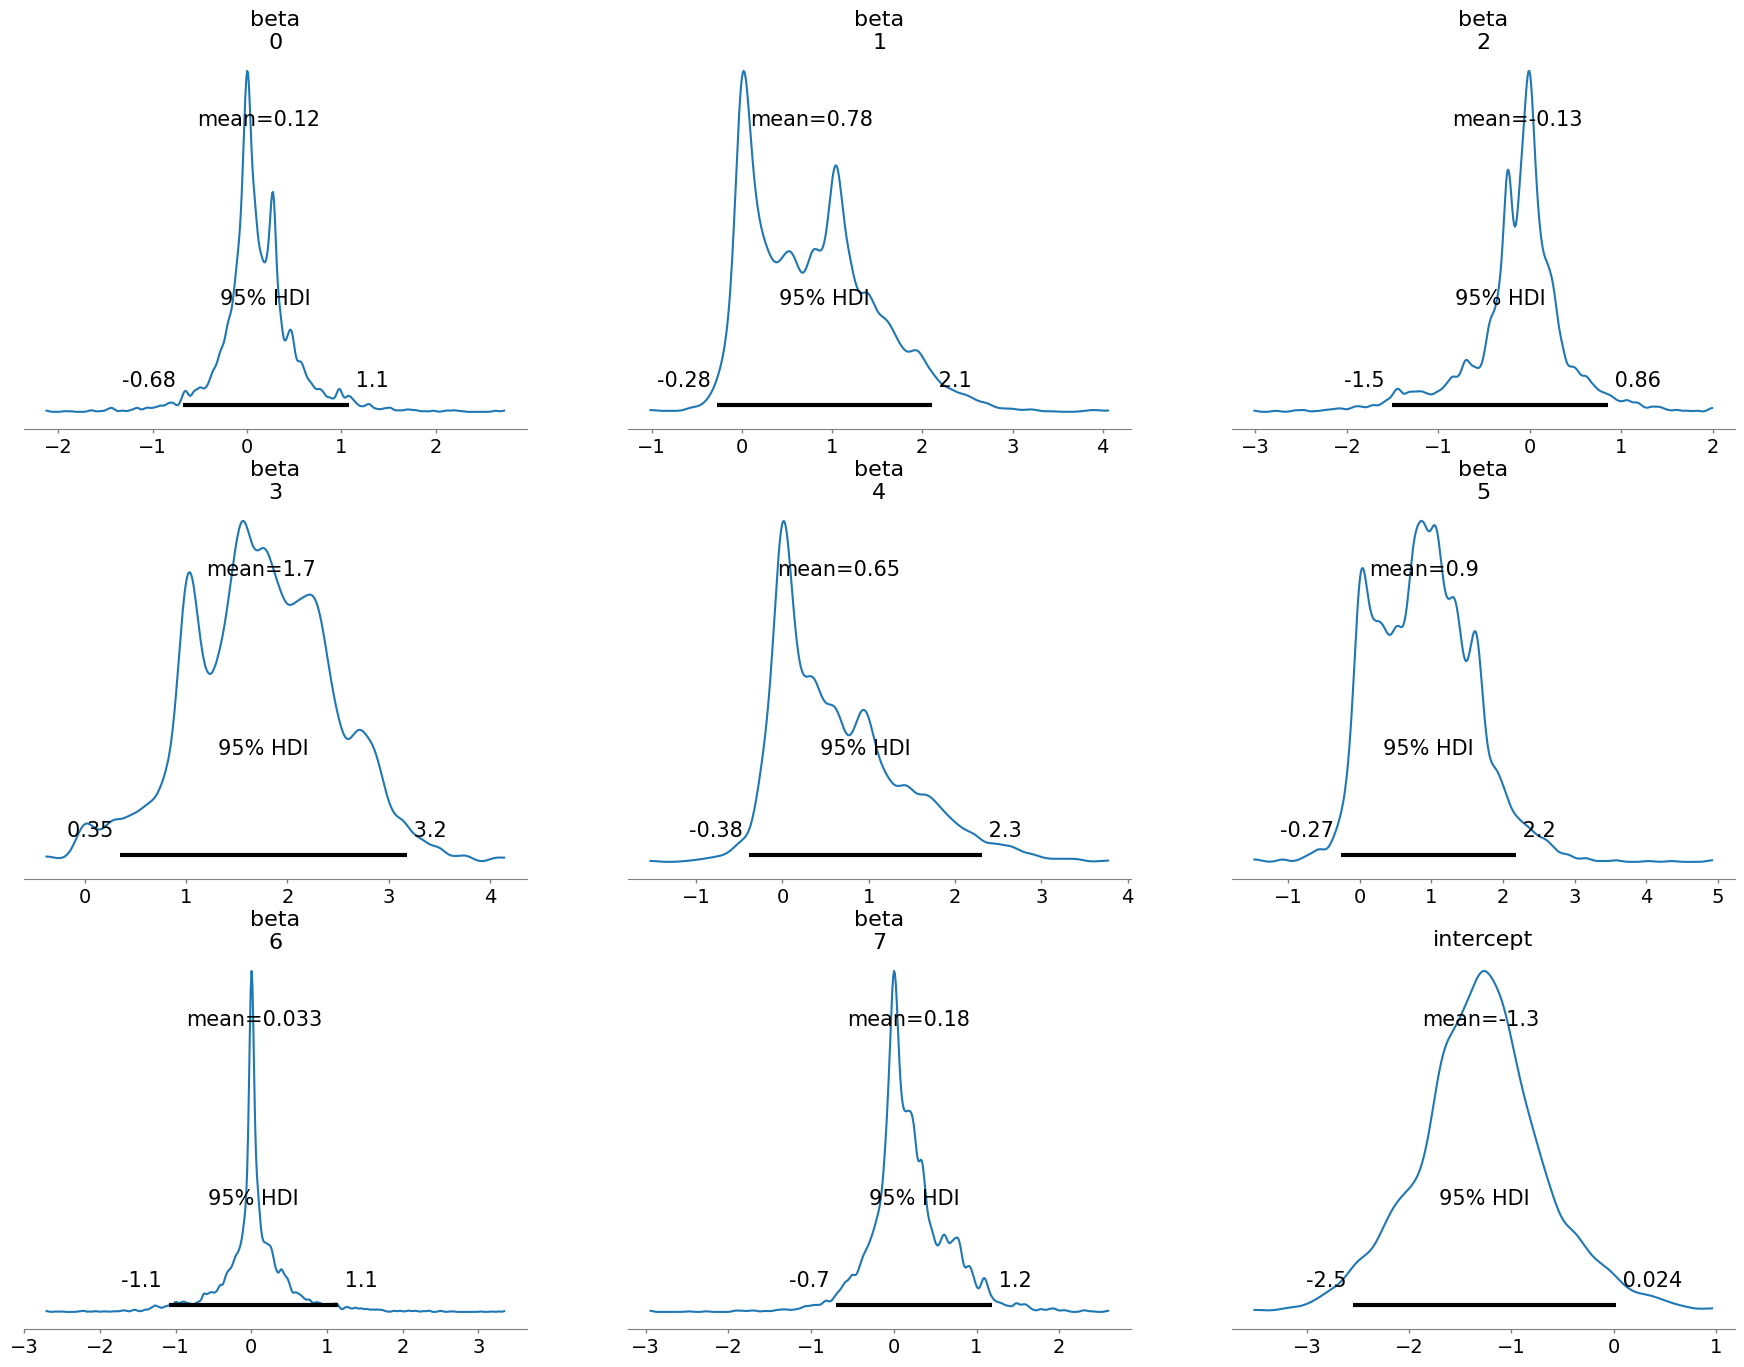

In [34]:
a = 1  # Shape parameter for Gamma prior
b = 0.1  # Scale parameter for Gamma prior

with pm.Model() as bayesian_lasso:
    # Prior for regularization parameter lambda
    lambda_param = pm.Gamma("lambda", alpha=a, beta=b)
    
    # Priors for the regression coefficients
    tau = pm.Exponential("tau", lambda_param, shape=X_train.shape[1])
    beta = pm.Normal("beta", mu=0, sigma=tau, shape=X_train.shape[1])
    
    # Prior for intercept
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Likelihood (data model)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = intercept + pm.math.dot(X_train, beta)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_train)

    # Inference
    trace = pm.sample(1000, tune=1000, target_accept=0.9,  return_inferencedata=True, progressbar=True)

# Posterior summaries
pm.plot_posterior(trace, var_names=["beta", "intercept"], hdi_prob=0.95)

summary = az.summary(trace, var_names=["beta", "intercept"], hdi_prob=0.95)
display(summary)

# Retrieve the posterior means for the coefficients
beta_post_mean = trace.posterior["beta"].mean(axis=(0,1))
intercept_post_mean = trace.posterior["intercept"].mean()
print("Bayesian Lasso Results:")
print("Posterior Means for Coefficients:", beta_post_mean)
print("Posterior Mean for Intercept:", intercept_post_mean)

In [35]:
# Posterior Predictions
with bayesian_lasso:
    posterior_predictive = pm.sample_posterior_predictive(trace)

posterior_predictive_data = posterior_predictive['posterior_predictive']
# print("Available keys inside posterior_predictive:", list(posterior_predictive_data.keys()))

# Extract the predictions
y_pred_samples = posterior_predictive_data['y'].values
# Compute posterior mean of y for each observation (across all chains and draws)
y_pred_mean = y_pred_samples.mean(axis=(0, 1))  # Averaging over chains (axis=0) and draws (axis=1)
# Extract observed y values
y_obs = posterior_predictive['observed_data']['y'].values

# Compute the Mean Squared Error (MSE)
mse = mean_squared_error(y_obs, y_pred_mean)
print(f"MSE: {mse:.3f}")

Sampling: [y]


Output()

MSE: 7.950


In [36]:
# Generate predictions for the test dataset
with bayesian_lasso:
    # Extract posterior samples of beta and intercept
    beta_samples = trace.posterior["beta"].stack(samples=("chain", "draw")).values
    intercept_samples = trace.posterior["intercept"].stack(samples=("chain", "draw")).values

# Compute predicted means for X_test
y_pred_test_samples = np.dot(X_test, beta_samples) + intercept_samples
# Compute posterior predictive mean (average over all samples)
y_pred_test_mean = y_pred_test_samples.mean(axis=1)  # Averaging over all posterior samples

# Compute the Mean Squared Error (MSE) for the test set
mse_test = mean_squared_error(y_test, y_pred_test_mean)
print(f"MSE on Test Set: {mse_test:.3f}")


MSE on Test Set: 14.115


- With mode estimators :

In [37]:
a = 1  # Shape parameter for Gamma prior
b = 0.1  # Scale parameter for Gamma prior

with pm.Model() as bayesian_lasso:
    # Prior for regularization parameter lambda
    lambda_param = pm.Gamma("lambda", alpha=a, beta=b)
    
    # Priors for the regression coefficients
    tau = pm.Exponential("tau", lambda_param, shape=X_train.shape[1])
    beta = pm.Normal("beta", mu=0, sigma=tau, shape=X_train.shape[1])
    
    # Prior for intercept
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Likelihood (data model)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = intercept + pm.math.dot(X_train, beta)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_train)

    # Find the posterior mode
    map_estimate = pm.find_MAP()

# Extract posterior mode for beta and intercept
beta_post_mode = map_estimate["beta"]
intercept_post_mode = map_estimate["intercept"]

# Display results
print("Bayesian Lasso Results:")
print("Posterior Mode for Coefficients:", beta_post_mode)
print("Posterior Mode for Intercept:", intercept_post_mode)

Output()

Bayesian Lasso Results:
Posterior Mode for Coefficients: [-2.04274103e-14 -4.64801112e-12  9.15562142e-13 -1.04373430e-11
  2.92319314e-13  4.96217578e-12  6.21443812e-13  5.87619708e-13]
Posterior Mode for Intercept: -14.482705187687326


Comparisons

In [38]:
# True coefficients
print("True beta: ", beta2)

# Frequentist Lasso Coefficients
print('\n----- FREQUENTIST LASSO -----')
lasso = LassoCV(cv=5).fit(X_train, y_train)
print("\nFrequentist Lasso Coefficients:", best_model.coef_)
print(f"MSE on Train Set: {mse_train_freq:.3f}")
print(f"MSE on Test Set: {mse_test_freq:.3f}")

# Bayesian Lasso Posterior Means
print('\n----- BAYESIAN LASSO -----')
# beta_post_mean = trace.posterior["beta"].mean(axis=(0, 1))
print("\nBayesian Lasso Posterior Means:", beta_post_mean)
print(f"MSE on Train Set: {mse:.3f}")
print(f"MSE on Test Set: {mse_test:.3f}")

True beta:  [0.65 0.65 0.65 0.65 0.65 0.65 0.65 0.65]

----- FREQUENTIST LASSO -----

Frequentist Lasso Coefficients: [0. 0. 0. 0. 0. 0. 0. 0.]
MSE on Train Set: 25.886
MSE on Test Set: 20.020

----- BAYESIAN LASSO -----

Bayesian Lasso Posterior Means: <xarray.DataArray 'beta' (beta_dim_0: 8)> Size: 64B
array([ 0.12132149,  0.77716059, -0.13189123,  1.73772888,  0.64826723,
        0.89825987,  0.03287038,  0.17756836])
Coordinates:
  * beta_dim_0  (beta_dim_0) int32 32B 0 1 2 3 4 5 6 7
MSE on Train Set: 7.950
MSE on Test Set: 14.115


#### Example 3 

Example 3 aims to test a scenario in which the number of regressors is higher than the number of observations. Here we have $p=50$ predictors and $n=30$ observations.

In [44]:
# Parameters
n_train = 30 # Number of training samples
n_test = 30  # Number of testing samples
p = 50       # Number of predictors
beta3 = np.random.randn(50)
sigma = 3
corr_decay = 0.5

# Create covariance matrix based on corr(i, j) = 0.5^|i-j|
cov_matrix = np.fromfunction(
    lambda i, j: corr_decay ** np.abs(i - j),
    (p, p),
    dtype=int
)

# Generate training predictors and noise
X_train = np.random.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n_train)
epsilon_train = np.random.normal(loc=0, scale=1, size=n_train)

# Generate training response (y)
y_train = X_train @ beta3 + sigma * epsilon_train

# Generate testing predictors and noise
X_test = np.random.multivariate_normal(mean=np.zeros(p), cov=cov_matrix, size=n_test)
epsilon_test = np.random.normal(loc=0, scale=1, size=n_test)

# Generate testing response (y)
y_test = X_test @ beta3 + sigma * epsilon_test

# Output data
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (30, 50) (30,)
Testing data shape: (30, 50) (30,)


In [40]:
# # Calculate empirical correlation matrix
# corr_matrix = np.corrcoef(X_train, rowvar=False)

# # Calculate theoretical correlation matrix
# p = X_train.shape[1]
# theoretical_corr_matrix = np.fromfunction(
#     lambda i, j: corr_decay ** np.abs(i - j),
#     (p, p),
#     dtype=int
# )

# # Plot both side by side
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[0], cbar=False)
# axes[0].set_title("Empirical Correlation Matrix (X_train)")
# sns.heatmap(theoretical_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[1], cbar=False)
# axes[1].set_title("Theoretical Correlation Matrix (0.5^|i-j|)")

# plt.show()

In [45]:
# Simple linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(lr.intercept_)
print(lr.coef_)

-1.4602039356261425
[ 5.54682089e-01  6.36957882e-01 -5.22257239e-01 -8.41800518e-01
  1.31474707e-02 -1.54720465e+00  1.74558945e+00  6.25805096e-01
  4.57804323e-01 -1.73362672e+00  3.10109982e-01  4.47842071e-01
 -2.98191060e-01  1.51445750e+00  8.89408549e-01 -1.14335382e+00
  4.36802203e-01 -3.52576540e-01 -3.17765963e-01  4.34603642e-01
 -1.01397618e+00  3.22654339e-01 -3.28645483e-01 -1.79337742e+00
  6.42930905e-01  1.06889279e+00  1.04497673e-01 -2.09517697e-01
  6.16392809e-01  1.02590208e+00  1.24762436e+00  1.37427882e-01
 -1.97020889e-01  4.93409449e-01  9.62689127e-01  3.12339620e-01
 -8.95101823e-01  7.63888958e-01  4.43327205e-01  5.93241294e-01
  1.69177398e+00 -2.14166060e-01  1.74684396e-03  1.05048834e-01
  1.32144901e+00  2.51456857e-01 -5.15813926e-01  6.45354348e-01
 -5.30018230e-01  1.19742754e+00]


##### Frequentist Lasso

In [46]:
# Define parameter grid for alpha (regularization parameter)
param_grid = {'alpha': [0.01, 0.1, 0.3, 0.5, 0.9, 1, 3, 5, 10]}

# Perform Grid Search with Cross-Validation
grid = GridSearchCV(Lasso(fit_intercept=True), param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Retrieve the best alpha and corresponding model
best_alpha = grid.best_params_['alpha']
best_model = grid.best_estimator_

# Predictions using the best model
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Evaluation
mse_train_freq = mean_squared_error(y_train, y_pred_train)
mse_test_freq = mean_squared_error(y_test, y_pred_test)

# Print the results
print("Frequentist Lasso Results with Hyperparameter Tuning:")
print(f"Best alpha: {best_alpha}")
print(f"Train MSE: {mse_train_freq:.3f}")
print(f"Test MSE: {mse_test_freq:.3f}")
print("Best Coefficients:", best_model.coef_)

Frequentist Lasso Results with Hyperparameter Tuning:
Best alpha: 0.5
Train MSE: 6.509
Test MSE: 33.494
Best Coefficients: [ 0.          0.         -0.         -0.20829778 -0.         -0.
  1.28990645  0.         -0.         -0.          0.          0.
 -0.          0.78157443  0.         -0.          0.         -0.
  0.          0.          0.          0.         -0.         -0.0936839
  0.          0.62962377  0.          0.          0.          0.16876741
  1.55549191 -0.         -0.          0.28120313  1.57070384  0.
 -0.          0.11031774  0.          0.          1.26264412  0.
  0.28687714  0.          0.86378251  0.          0.          0.
 -0.          0.        ]


c:\Users\marie\OneDrive\Documents\cours\ensae\3A\stats bayésiennes\.venvSB\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.223e-01, tolerance: 9.091e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\marie\OneDrive\Documents\cours\ensae\3A\stats bayésiennes\.venvSB\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.190e-01, tolerance: 6.601e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\marie\OneDrive\Documents\cours\ensae\3A\stats bayésiennes\.venvSB\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You mi

##### Bayesian Lasso

- With mean estimators :

In [ ]:
a = 1  # Shape parameter for Gamma prior
b = 0.1  # Scale parameter for Gamma prior

with pm.Model() as bayesian_lasso:
    # Prior for regularization parameter lambda
    lambda_param = pm.Gamma("lambda", alpha=a, beta=b)
    
    # Priors for the regression coefficients
    tau = pm.Exponential("tau", lambda_param, shape=X_train.shape[1])
    beta = pm.Normal("beta", mu=0, sigma=tau, shape=X_train.shape[1])
    
    # Prior for intercept
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Likelihood (data model)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = intercept + pm.math.dot(X_train, beta)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_train)

    # Inference
    trace = pm.sample(1000, tune=1000, target_accept=0.9,  return_inferencedata=True, progressbar=True)

# Posterior summaries
pm.plot_posterior(trace, var_names=["beta", "intercept"], hdi_prob=0.95)

summary = az.summary(trace, var_names=["beta", "intercept"], hdi_prob=0.95)
display(summary)

# Retrieve the posterior means for the coefficients
beta_post_mean = trace.posterior["beta"].mean(axis=(0,1))
intercept_post_mean = trace.posterior["intercept"].mean()
print("Bayesian Lasso Results:")
print("Posterior Means for Coefficients:", beta_post_mean)
print("Posterior Mean for Intercept:", intercept_post_mean)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda, tau, beta, intercept, sigma]


Output()

In [ ]:
# Posterior Predictions
with bayesian_lasso:
    posterior_predictive = pm.sample_posterior_predictive(trace)

posterior_predictive_data = posterior_predictive['posterior_predictive']
# print("Available keys inside posterior_predictive:", list(posterior_predictive_data.keys()))

# Extract the predictions
y_pred_samples = posterior_predictive_data['y'].values
# Compute posterior mean of y for each observation (across all chains and draws)
y_pred_mean = y_pred_samples.mean(axis=(0, 1))  # Averaging over chains (axis=0) and draws (axis=1)
# Extract observed y values
y_obs = posterior_predictive['observed_data']['y'].values

# Compute the Mean Squared Error (MSE)
mse = mean_squared_error(y_obs, y_pred_mean)
print(f"MSE: {mse:.3f}")

In [ ]:
# Generate predictions for the test dataset
with bayesian_lasso:
    # Extract posterior samples of beta and intercept
    beta_samples = trace.posterior["beta"].stack(samples=("chain", "draw")).values
    intercept_samples = trace.posterior["intercept"].stack(samples=("chain", "draw")).values

# Compute predicted means for X_test
y_pred_test_samples = np.dot(X_test, beta_samples) + intercept_samples
# Compute posterior predictive mean (average over all samples)
y_pred_test_mean = y_pred_test_samples.mean(axis=1)  # Averaging over all posterior samples

# Compute the Mean Squared Error (MSE) for the test set
mse_test = mean_squared_error(y_test, y_pred_test_mean)
print(f"MSE on Test Set: {mse_test:.3f}")

- With mode estimators :

In [ ]:
a = 1  # Shape parameter for Gamma prior
b = 0.1  # Scale parameter for Gamma prior

with pm.Model() as bayesian_lasso:
    # Prior for regularization parameter lambda
    lambda_param = pm.Gamma("lambda", alpha=a, beta=b)
    
    # Priors for the regression coefficients
    tau = pm.Exponential("tau", lambda_param, shape=X_train.shape[1])
    beta = pm.Normal("beta", mu=0, sigma=tau, shape=X_train.shape[1])
    
    # Prior for intercept
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Likelihood (data model)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = intercept + pm.math.dot(X_train, beta)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_train)

    # Find the posterior mode
    map_estimate = pm.find_MAP()

# Extract posterior mode for beta and intercept
beta_post_mode = map_estimate["beta"]
intercept_post_mode = map_estimate["intercept"]

# Display results
print("Bayesian Lasso Results:")
print("Posterior Mode for Coefficients:", beta_post_mode)
print("Posterior Mode for Intercept:", intercept_post_mode)

Comparisons

In [ ]:
# True coefficients
print("True beta: ", beta3)

# Frequentist Lasso Coefficients
print('\n----- FREQUENTIST LASSO -----')
# lasso = LassoCV(cv=5).fit(X_train, y_train)
print("\nFrequentist Lasso Coefficients:", best_model.coef_)
print(f"MSE on Train Set: {mse_train_freq:.3f}")
print(f"MSE on Test Set: {mse_test_freq:.3f}")

# Bayesian Lasso Posterior Means
print('\n----- BAYESIAN LASSO -----')
# beta_post_mean = trace.posterior["beta"].mean(axis=(0, 1))
print("\nBayesian Lasso Posterior Means:", beta_post_mean)
print(f"MSE on Train Set: {mse:.3f}")
print(f"MSE on Test Set: {mse_test:.3f}")